In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
print(torch.__version__)
import torchvision
from torchvision import datasets, transforms

import helper

0.4.1


In [2]:
data_dir = '/Users/akshaykulkarni/flowers/train/'
batch_size = 32
tf = transforms.Compose([transforms.Resize((255, 255)),
                         transforms.ToTensor(),
                        ])

train_dataset = datasets.ImageFolder(data_dir, transform = tf)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True)

data_dir = '/Users/akshaykulkarni/flowers/test/'

test_dataset = datasets.ImageFolder(data_dir, transform = tf)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle = True)

torch.Size([32, 3, 255, 255])
torch.Size([32])


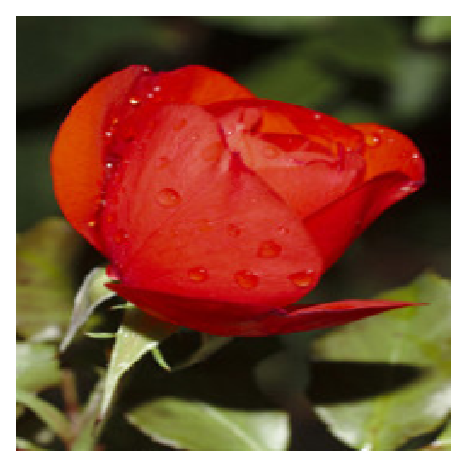

In [3]:
images, labels = next(iter(test_loader))
print(images.shape)
helper.imshow(images[0], normalize = False)
print(labels.shape)

In [4]:
a = images.view(images.shape[0], -1)
print(a.shape)

torch.Size([32, 195075])


In [38]:
m = len(train_loader) * batch_size
n = 255 * 255 * 3
learning_rate = 1e-2
W = torch.randn(n, 1)
b = 0
num_epochs = 10

In [22]:
def binary_cross_entropy(A, Y):
    loss = (-1 / Y.shape[0]) * (torch.matmul(torch.log(A), Y) + torch.matmul(torch.log(1 - A), (1 - Y)))
    return loss

In [23]:
def sigmoid(x):
    return (1 / (1 + torch.exp(-x)))

In [26]:
def forward(x, y):
    out = torch.add(torch.matmul(W.t(), x), b)
    out = sigmoid(out)
    # size - (1, batch_size)
    loss = binary_cross_entropy(out, y)
    return loss, out

In [25]:
def backward(A, Y, X):
    dz = A - Y.resize_(Y.shape[0])
    dw = (1 / Y.shape[0]) * torch.matmul(X, dz.t())
    db = (1 / Y.shape[0]) * torch.sum(dz)
    return dw, db

In [ ]:
# Training Loop
for i in range(10):
    epoch_loss = 0
    for batch_idx, (images, labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()
            W = W.cuda()
            b = b.cuda()
        labels = labels.float()
        images = images.view(-1, images.shape[0]).float()
#         print(images.shape)
#         print(W.shape)
#         print('Images and labels modified as required')
        loss = forward(images, labels)
#         print('Forward propagation done')
#         _, index_pred = torch.max(pred, 0)
        
        epoch_loss += loss.item()
#         print('Current loss calculated')
        dz = pred - labels.resize_(labels.shape[0])
#         print(dz.shape)
#         print(images.shape)
        dw = (1 / m) * torch.matmul(dz, images.t())
#         print(dw.shape)
        db = (1 / m) * torch.sum(dz)
#         print(db.shape)
#         print('back prop done')
        dw2 = learning_rate * dw
#         print(dw2.shape)
#         print(W.shape)
        W -= dw2.resize_(dw2.shape[0], 1)
        b -= (learning_rate * db)
#         print('Loss at step ', batch_idx, ' = ', epoch_loss)

    print('Loss at epoch', i, ' = ', epoch_loss)
    
    acc = 0
    for batch_idx, (images, labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()
            W = W.cuda()
            b = b.cuda()
        labels = labels.float()
        images = images.view(-1, images.shape[0]).float()
        
        pred = forward(images)
        pred = (pred >= 0.5).float()
        
        mismatch = torch.abs(pred - labels.resize_(labels.shape[0]))
        acc += torch.sum(mismatch)
        
    acc /= (len(train_loader) * batch_size)
    print('Training accuracy at epoch ', i, ' = ', acc.item() * 100)
    
    acc = 0
    for batch_idx, (images, labels) in enumerate(test_loader):
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()
            W = W.cuda()
            b = b.cuda()
        labels = labels.float()
        images = images.view(-1, images.shape[0]).float()
        
        pred = forward(images)
        pred = (pred >= 0.5).float()
        
        mismatch = torch.abs(pred - labels.resize_(labels.shape[0]))
        acc += torch.sum(mismatch)
        
    acc /= (len(test_loader) * batch_size)
    print('Validation accuracy at epoch ', i, ' = ', acc.item() * 100)

In [39]:
for i in range(num_epochs):
    epoch_loss = 0
    for batch_idx, (images, labels) in enumerate(train_loader):
        # convert to GPU tensors
        if torch.cuda.is_available():
            images, labels = images.cuda(), labels.cuda()
            W, b = W.cuda(), b.cuda()
        
        # convert to float and resize images to (n, batch_size) size
        labels = labels.float()
        images = images.view(-1, images.shape[0]).float()
        
        loss, pred = forward(images, labels)
        epoch_loss += loss.item()
        
        dw, db = backward(pred, labels, images)
        
        # updating weights
        W -= learning_rate * dw
        b -= learning_rate * db
    
    print(W)
    print(b)
        
    epoch_loss /= batch_size
    print('Loss at epoch ', i, ' = ', epoch_loss)

tensor([[ 0.1547],
        [-0.6218],
        [-0.7553],
        ...,
        [ 0.2772],
        [-0.6372],
        [-0.6126]])
tensor(-0.0018)
Loss at epoch  0  =  nan


KeyboardInterrupt: 

In [36]:
acc = 0
for batch_idx, (images, labels) in enumerate(train_loader):
    if torch.cuda.is_available():
        images = images.cuda()
        labels = labels.cuda()
        W = W.cuda()
        b = b.cuda()
    labels = labels.float()
    images = images.view(-1, images.shape[0]).float()

    loss, pred = forward(images, labels)
    pred = (pred >= 0.5).float()

    mismatch = torch.abs(pred - labels.resize_(labels.shape[0]))
    acc += torch.sum(mismatch)

acc /= (len(train_loader) * batch_size)
print('Training accuracy = ', acc.item() * 100)

acc = 0
for batch_idx, (images, labels) in enumerate(test_loader):
    if torch.cuda.is_available():
        images = images.cuda()
        labels = labels.cuda()
        W = W.cuda()
        b = b.cuda()
    labels = labels.float()
    images = images.view(-1, images.shape[0]).float()

    loss, pred = forward(images, labels)
    pred = (pred >= 0.5).float()

    mismatch = torch.abs(pred - labels.resize_(labels.shape[0]))
    acc += torch.sum(mismatch)

acc /= (len(test_loader) * batch_size)
print('Validation accuracy = ', acc.item() * 100)

Training accuracy =  48.86363744735718
Validation accuracy =  39.84375


In [37]:
a = torch.randn((2, 3))
print(a)
print(W)
print(b)

tensor([[-1.1650, -0.8320, -0.0902],
        [-0.1518, -0.9138,  0.2939]])
tensor([[-0.0345],
        [-0.6512],
        [ 0.0733],
        ...,
        [-0.3884],
        [ 0.0124],
        [ 1.1728]])
tensor(-0.0102)


In [125]:
b = torch.transpose(a, 1, 0)
print(b)

tensor([[ 1.0537,  1.7875],
        [-0.1413,  0.5772],
        [-1.7341, -0.5618]])


In [17]:
a = a > 0.5
print(a)

tensor([[0, 1, 0],
        [0, 0, 1]], dtype=torch.uint8)


In [20]:
print(len(train_loader) * batch_size)

1408
